In [30]:
import pandas as pd
from pandas.plotting import autocorrelation_plot
import numpy as np
import re
import seaborn as sns
import time
import lightgbm as lgbm
from pathlib import Path
import pickle
from catboost import CatBoostClassifier, cv, Pool
import scikitplot as skplt
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, tpe, partial

import itertools
from itertools import combinations

import scipy as sp
from scipy.stats import pearsonr, chi2_contingency

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap

import datetime as dt
from dateutil import relativedelta

from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_colwidth = None
pd.options.display.max_rows = None

import statsmodels.api as sm 
from statsmodels.graphics.api import abline_plot # For visualling evaluating predictions.
from statsmodels.stats.proportion import proportion_confint

import warnings # For handling error messages.
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings('ignore')

import sklearn.metrics as met
from sklearn import linear_model, preprocessing, model_selection, svm, datasets
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, RFE
from sklearn.linear_model import LassoCV, LogisticRegression, Lasso
from sklearn.metrics import plot_confusion_matrix, auc, confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale, StandardScaler, LabelEncoder, MinMaxScaler, Binarizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from bayes_opt import BayesianOptimization
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

import json
from io import StringIO

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
with open('ultimate_data_challenge.json') as f:
  data = json.load(f)
users = pd.DataFrame(data)

In [3]:
users.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [4]:
users.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


# Loading and cleaning login data

In [3]:
with open('logins.json') as f:
  data = json.load(f)
logins = pd.DataFrame(data)

logins.reset_index
logins.describe()

,login_time
count,93142
unique,92265
top,1970-01-06 21:45:52
freq,3


In [4]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   login_time  93142 non-null  object
dtypes: object(1)
memory usage: 727.8+ KB


In [5]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [6]:
logins['login_time'] = pd.to_datetime(logins['login_time'])
logins['login_time'] = logins['login_time'].dt.floor('T')
logins = logins.set_index('login_time')
logins['num_logins']=1
logins.head()

,num_logins
login_time,
1970-01-01 20:13:00,1
1970-01-01 20:16:00,1
1970-01-01 20:16:00,1
1970-01-01 20:16:00,1
1970-01-01 20:26:00,1


In [7]:
logins = logins.resample('1T').sum()
logins.describe()

,num_logins
count,146806.000000
mean,0.634456
std,0.951275
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,10.000000


In [8]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 146806 entries, 1970-01-01 20:12:00 to 1970-04-13 18:57:00
Freq: T
Data columns (total 1 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   num_logins  146806 non-null  int64
dtypes: int64(1)
memory usage: 2.2 MB


In [9]:
logins.head()

,num_logins
login_time,
1970-01-01 20:12:00,1
1970-01-01 20:13:00,1
1970-01-01 20:14:00,0
1970-01-01 20:15:00,0
1970-01-01 20:16:00,3


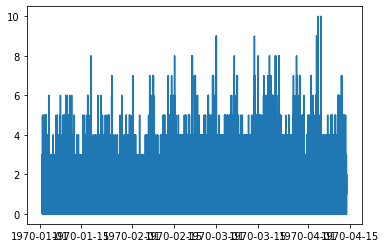

In [10]:
plt.plot(logins)

# Resampling the data at 15min frequency

In [11]:
logins_15min = logins.resample('15T').sum()

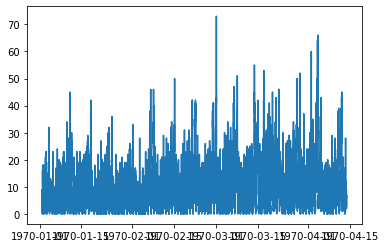

In [12]:
plt.plot(logins_15min)

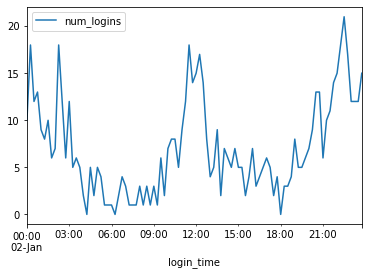

In [13]:
logins_15min.loc['1970-01-02':'1970-01-02'].plot()

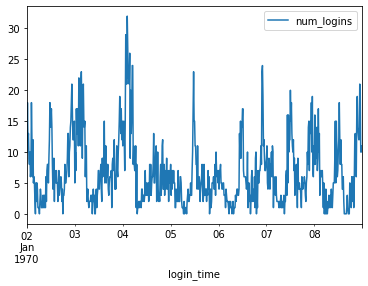

In [14]:
logins_15min.loc['1970-01-02':'1970-01-08'].plot()

# The login data looks stationary

In [15]:
results = adfuller(logins_15min.loc['1970-01-02':])
results
# 0th element shows more likely to be stationary based on how negative it is
# 1st element is p-value; <.05 means we reject the null hypothesis that it's non-stationary

(-10.336399736943584,
 2.7566784659639917e-18,
 38,
 9733,
 {'1%': -3.4310220461817127,
  '5%': -2.8618370035382275,
  '10%': -2.566928089859835},
 56289.024923026416)

# But I'm not sure how to interpret the ACF and PCF.  What should my range for hyperparameters be?  Should it be 96 since that's how many rows are in a day?

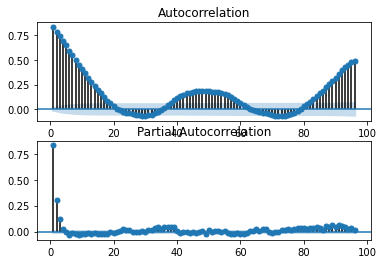

In [16]:
fig, (ax1, ax2) = plt.subplots(2,1)
plot_acf(logins_15min, lags=96, zero=False, ax=ax1)
plot_pacf(logins_15min, lags=96, zero=False, ax=ax2)
plt.show()

In [31]:
order_aic_bic = []
# loop over AR order
for p in range(20):
    # loop over MA order
    for q in range(20):
        try:
            # fit model
            model = SARIMAX(logins_15min, order=(p,0,q))
            results = model.fit()
            # add order and scores to list
            order_aic_bic.append((p,q,results.aic,results.bic))
        except:
            # print aic and bic as none when fails
            order_aic_bic.append((p,q,None,None))
        
# make df of model order and aic/bic scores
order_df_15min = pd.DataFrame(order_aic_bic, columns=['p','q','aic','bic'])

# I tested hyperparameters through 20.  And (19,1) looks best.  Should I bother trying more?  Or should I go with (3,10)?

In [32]:
# sort by aic
order_df_15min.sort_values('aic')

,p,q,aic,bic
381,19,1,56669.875102,56820.842262
382,19,2,56673.652965,56831.809038
383,19,3,56695.620743,56860.965729
384,19,4,56703.084384,56875.618282
386,19,6,56706.863034,56893.774757
70,3,10,56715.074791,56815.719565
326,16,6,56718.985711,56884.330697
306,15,6,56721.685120,56879.841194
52,2,12,56729.321751,56837.155437
285,14,5,56734.029487,56877.807736


In [33]:
# sort by bic
order_df_15min.sort_values('bic')

,p,q,aic,bic
70,3,10,56715.074791,56815.719565
381,19,1,56669.875102,56820.842262
382,19,2,56673.652965,56831.809038
52,2,12,56729.321751,56837.155437
129,6,9,56737.786254,56852.808853
149,7,9,56737.082468,56859.293979
383,19,3,56695.620743,56860.965729
163,8,3,56775.419811,56861.686760
384,19,4,56703.084384,56875.618282
285,14,5,56734.029487,56877.807736


In [ ]:
order_aic_bic = []
# loop over AR order
for p in range(20,100):
    # loop over MA order
    for q in range(0,3):
        try:
            # fit model
            model = SARIMAX(logins_15min, order=(p,0,q))
            results = model.fit()
            # add order and scores to list
            order_aic_bic.append((p,q,results.aic,results.bic))
        except:
            # print aic and bic as none when fails
            order_aic_bic.append((p,q,None,None))
        
# make df of model order and aic/bic scores
order_df_15min = pd.DataFrame(order_aic_bic, columns=['p','q','aic','bic'])

In [ ]:
# sort by aic
order_df_15min.sort_values('aic')

In [ ]:
# sort by bic
order_df_15min.sort_values('bic')

# Do these look right?

3.116790588154646


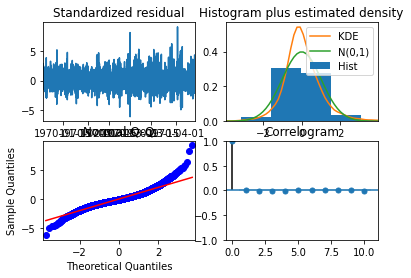

In [19]:
model = SARIMAX(logins_15min, order=(19,0,1))
results = model.fit()
# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(results.resid))
# Print mean absolute error
print(mae)
# Create the 4 diagostics plots
results.plot_diagnostics()
plt.show()

In [18]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:             num_logins   No. Observations:                 9788
Model:              SARIMAX(19, 0, 1)   Log Likelihood              -28313.938
Date:                Mon, 15 Feb 2021   AIC                          56669.875
Time:                        19:50:50   BIC                          56820.842
Sample:                    01-01-1970   HQIC                         56721.031
                         - 04-13-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5203      0.007    204.619      0.000       1.506       1.535
ar.L2         -0.2984      0.013    -23.373      0.000      -0.323      -0.273
ar.L3         -0.1143      0.013     -8.691      0.0

# Or should I just be using seasonal decomp...

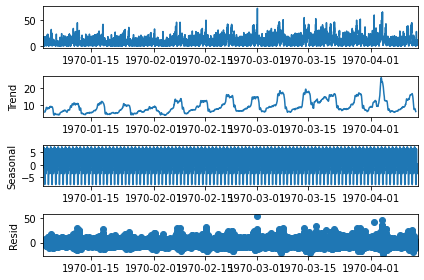

In [32]:
decomp_results = seasonal_decompose(logins_15min, freq=96)
decomp_results.plot()
plt.show()

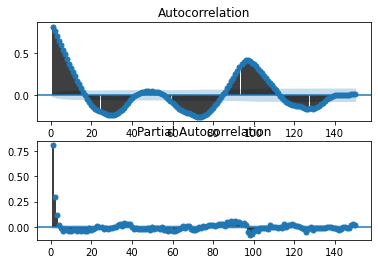

In [35]:
# Subtract the rolling mean
logins_15min_rolling = logins_15min - logins_15min.rolling(100).mean()

# Drop the NaN values
logins_15min_rolling = logins_15min_rolling.dropna()

# Plot the ACF and PCF
fig, (ax1, ax2) = plt.subplots(2,1)
plot_acf(logins_15min_rolling, lags=150, zero=False, ax=ax1)
plot_pacf(logins_15min_rolling, lags=150, zero=False, ax=ax2)
plt.show()

# This is resampling by day

In [21]:
logins_day = logins.resample('1d').sum()

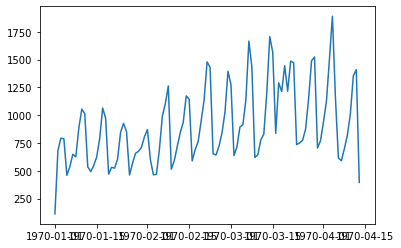

In [22]:
plt.plot(logins_day)

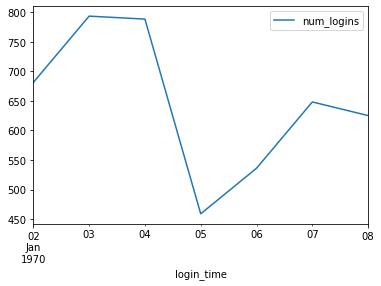

In [23]:
logins_day.loc['1970-01-02':'1970-01-08'].plot()

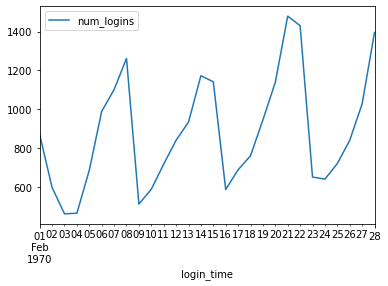

In [24]:
logins_day.loc['1970-02-01':'1970-02-28'].plot()

In [25]:
results = adfuller(logins_day.loc['1970-01-02':])
results
# 0th element shows more likely to be stationary based on how negative it is
# 1st element is p-value; <.05 means we reject the null hypothesis that it's non-stationary

(-1.170464719665907,
 0.686170290864084,
 13,
 88,
 {'1%': -3.506944401824286,
  '5%': -2.894989819214876,
  '10%': -2.584614550619835},
 1158.9769986560846)

In [26]:
logins_day_diff = logins_day.diff().dropna()
results = adfuller(logins_day_diff.loc['1970-01-02':])
results
# 0th element shows more likely to be stationary based on how negative it is
# 1st element is p-value; <.05 means we reject the null hypothesis that it's non-stationary

(-4.224797553035285,
 0.0005980298052094809,
 13,
 88,
 {'1%': -3.506944401824286,
  '5%': -2.894989819214876,
  '10%': -2.584614550619835},
 1156.4457889106202)

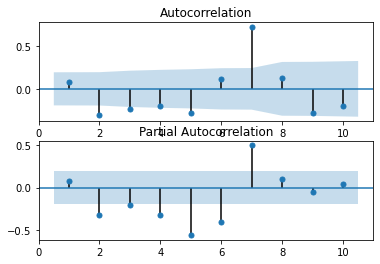

In [27]:
fig, (ax1, ax2) = plt.subplots(2,1)
plot_acf(logins_day_diff, lags=10, zero=False, ax=ax1)
plot_pacf(logins_day_diff, lags=10, zero=False, ax=ax2)
plt.show()

In [41]:
order_aic_bic = []
# loop over AR order
for p in range(10):
    # loop over MA order
    for q in range(10):
        try:
            # fit model
            model = SARIMAX(logins_day_diff, order=(p,0,q))
            results = model.fit()
            # add order and scores to list
            order_aic_bic.append((p,q,results.aic,results.bic))
        except:
            # print aic and bic as none when fails
            order_aic_bic.append((p,q,None,None))
        
# make df of model order and aic/bic scores
order_df_day = pd.DataFrame(order_aic_bic, columns=['p','q','aic','bic'])

# (7,7) looks like the best model.

In [42]:
# sort by aic
order_df_day.sort_values('aic')

,p,q,aic,bic
88,8,8,1350.369775,1394.994313
77,7,7,1350.694573,1390.069165
87,8,7,1351.647336,1393.646901
78,7,8,1351.891496,1393.891061
89,8,9,1352.650897,1399.900407
97,9,7,1352.813076,1397.437614
98,9,8,1353.891980,1401.141491
79,7,9,1354.617746,1399.242284
99,9,9,1355.445785,1405.320268
67,6,7,1356.239864,1392.989483


In [43]:
# sort by bic
order_df_day.sort_values('bic')

,p,q,aic,bic
70,7,0,1364.232528,1385.232310
80,8,0,1365.705289,1389.330044
71,7,1,1365.864907,1389.489662
77,7,7,1350.694573,1390.069165
63,6,3,1365.005493,1391.255221
72,7,2,1365.364098,1391.613826
82,8,2,1362.793583,1391.668284
61,6,1,1371.730916,1392.730699
65,6,5,1361.264394,1392.764067
74,7,4,1361.285048,1392.784722


118.31218008155953


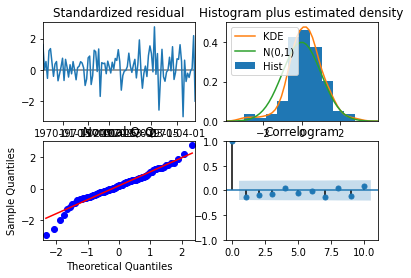

In [28]:
model = SARIMAX(logins_day_diff, order=(7,0,7))
results = model.fit()
# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(results.resid))
# Print mean absolute error
print(mae)
# Create the 4 diagostics plots
results.plot_diagnostics()
plt.show()

In [29]:
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:             num_logins   No. Observations:                  102
Model:               SARIMAX(7, 0, 7)   Log Likelihood                -660.347
Date:                Mon, 15 Feb 2021   AIC                           1350.695
Time:                        20:01:41   BIC                           1390.069
Sample:                    01-02-1970   HQIC                          1366.639
                         - 04-13-1970                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0910      0.139     -0.655      0.512      -0.363       0.181
ar.L2         -0.0871      0.135     -0.648      0.517      -0.351       0.177
ar.L3         -0.1153      0.127     -0.907      0.3